### 準備

In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO, SAC

from stable_baselines3.common.callbacks import EvalCallback

import os
import sys
sys.path.append(os.path.pardir)

from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *
from cpm_torch.Training.CPM_SAC_Policy import *

error: XDG_RUNTIME_DIR not set in the environment.


In [2]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250526-094333


### ハイパーパラメータ

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    size=(64, 64),  # 画像サイズ
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=75.0,  # 目標細胞面積 A_0
    L_0=40.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (64, 64), 'dim': 2, 'height': 64, 'width': 64, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 75.0, 'L_0': 40.0, 'T': 1.0}


### 環境

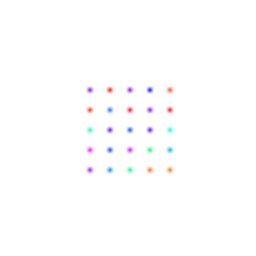

In [4]:
env = CPMEnv(config, device=device)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [5]:
eval_freq = 10000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 10

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 38740912
actor.latent_pi.fc1.weight: torch.Size([256, 9])
actor.latent_pi.fc1.bias: torch.Size([256])
actor.latent_pi.fc2.weight: torch.Size([256, 256])
actor.latent_pi.fc2.bias: torch.Size([256])
actor.latent_pi.fc3.weight: torch.Size([128, 256])
actor.latent_pi.fc3.bias: torch.Size([128])
actor.latent_pi.fc_mean.weight: torch.Size([4, 128])
actor.latent_pi.fc_mean.bias: torch.Size([4])
actor.latent_pi.fc_log_std.weight: torch.Size([4, 128])
actor.latent_pi.fc_log_std.bias: torch.Size([4])
actor.mu.weight: torch.Size([1936, 256])
actor.mu.bias: torch.Size([1936])
actor.log_std.weight: torch.Size([1936, 256])
actor.log_std.bias: torch.Size([1936])
critic.qf0.u_net1.downs.0.double_conv.0.weight: torch.Size([64, 1, 3, 3])
critic.qf0.u_net1.downs.0.double_conv.0.bias: torch.Size([64])
critic.qf0.u_net1.downs.0.double_conv.1.weight: torch.Size([64])
critic.qf0.u_net1.downs.0

/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

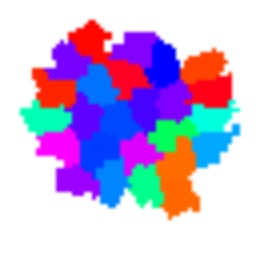

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 851       |
| time/              |           |
|    episodes        | 4         |
|    fps             | 3         |
|    time_elapsed    | 2013      |
|    total_timesteps | 8004      |
| train/             |           |
|    actor_loss      | -6.28e+03 |
|    critic_loss     | 4.63e+03  |
|    ent_coef        | 0.0943    |
|    ent_coef_loss   | -7.25e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 7903      |
----------------------------------


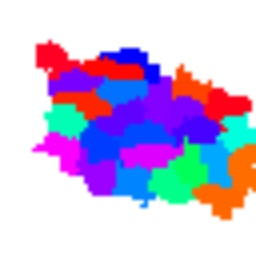

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 809       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 3         |
|    time_elapsed    | 4058      |
|    total_timesteps | 16008     |
| train/             |           |
|    actor_loss      | -3.01e+03 |
|    critic_loss     | 932       |
|    ent_coef        | 0.0097    |
|    ent_coef_loss   | -6.42e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 15907     |
----------------------------------


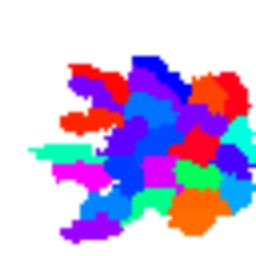

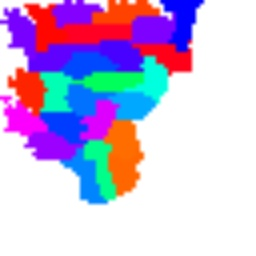

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 786       |
| time/              |           |
|    episodes        | 12        |
|    fps             | 3         |
|    time_elapsed    | 6103      |
|    total_timesteps | 24012     |
| train/             |           |
|    actor_loss      | -2.4e+03  |
|    critic_loss     | 396       |
|    ent_coef        | 0.00277   |
|    ent_coef_loss   | -1.88e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 23911     |
----------------------------------


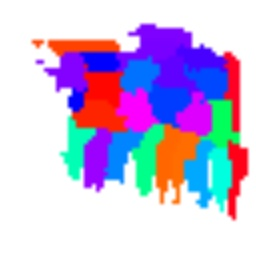

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 755       |
| time/              |           |
|    episodes        | 16        |
|    fps             | 3         |
|    time_elapsed    | 8146      |
|    total_timesteps | 32016     |
| train/             |           |
|    actor_loss      | -1.45e+03 |
|    critic_loss     | 317       |
|    ent_coef        | 0.00175   |
|    ent_coef_loss   | 4.65e+03  |
|    learning_rate   | 0.0003    |
|    n_updates       | 31915     |
----------------------------------


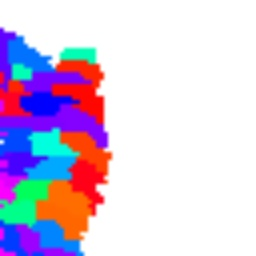

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 697      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 3        |
|    time_elapsed    | 10192    |
|    total_timesteps | 40020    |
| train/             |          |
|    actor_loss      | -999     |
|    critic_loss     | 278      |
|    ent_coef        | 0.00209  |
|    ent_coef_loss   | 150      |
|    learning_rate   | 0.0003   |
|    n_updates       | 39919    |
---------------------------------


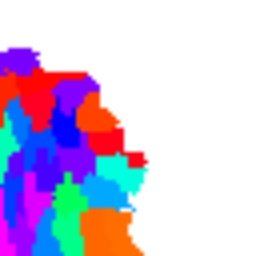

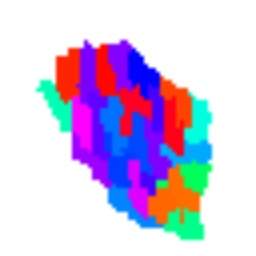

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 678      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 3        |
|    time_elapsed    | 12239    |
|    total_timesteps | 48024    |
| train/             |          |
|    actor_loss      | -698     |
|    critic_loss     | 99.4     |
|    ent_coef        | 0.00202  |
|    ent_coef_loss   | 207      |
|    learning_rate   | 0.0003   |
|    n_updates       | 47923    |
---------------------------------


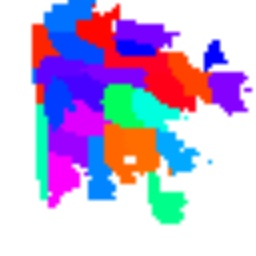

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 698      |
| time/              |          |
|    episodes        | 28       |
|    fps             | 3        |
|    time_elapsed    | 14281    |
|    total_timesteps | 56028    |
| train/             |          |
|    actor_loss      | -532     |
|    critic_loss     | 102      |
|    ent_coef        | 0.00202  |
|    ent_coef_loss   | -286     |
|    learning_rate   | 0.0003   |
|    n_updates       | 55927    |
---------------------------------


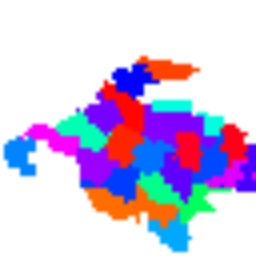

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 696      |
| time/              |          |
|    episodes        | 32       |
|    fps             | 3        |
|    time_elapsed    | 16323    |
|    total_timesteps | 64032    |
| train/             |          |
|    actor_loss      | -375     |
|    critic_loss     | 85.1     |
|    ent_coef        | 0.00145  |
|    ent_coef_loss   | 504      |
|    learning_rate   | 0.0003   |
|    n_updates       | 63931    |
---------------------------------


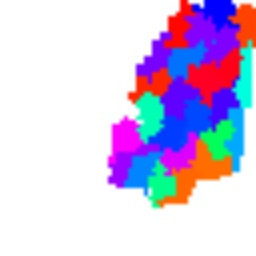

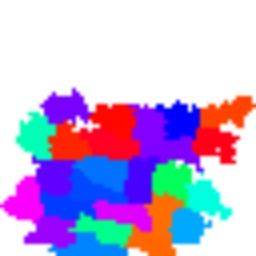

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 687      |
| time/              |          |
|    episodes        | 36       |
|    fps             | 3        |
|    time_elapsed    | 18367    |
|    total_timesteps | 72036    |
| train/             |          |
|    actor_loss      | -335     |
|    critic_loss     | 115      |
|    ent_coef        | 0.00111  |
|    ent_coef_loss   | -5.36    |
|    learning_rate   | 0.0003   |
|    n_updates       | 71935    |
---------------------------------


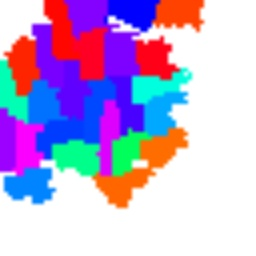

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 700      |
| time/              |          |
|    episodes        | 40       |
|    fps             | 3        |
|    time_elapsed    | 20414    |
|    total_timesteps | 80040    |
| train/             |          |
|    actor_loss      | -290     |
|    critic_loss     | 95.9     |
|    ent_coef        | 0.00077  |
|    ent_coef_loss   | 172      |
|    learning_rate   | 0.0003   |
|    n_updates       | 79939    |
---------------------------------


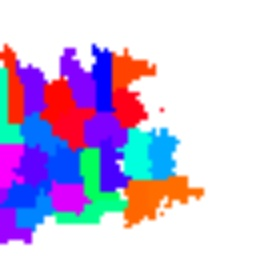

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 695      |
| time/              |          |
|    episodes        | 44       |
|    fps             | 3        |
|    time_elapsed    | 22459    |
|    total_timesteps | 88044    |
| train/             |          |
|    actor_loss      | -171     |
|    critic_loss     | 64.9     |
|    ent_coef        | 0.000546 |
|    ent_coef_loss   | 529      |
|    learning_rate   | 0.0003   |
|    n_updates       | 87943    |
---------------------------------


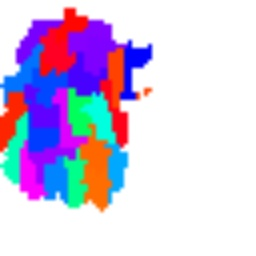

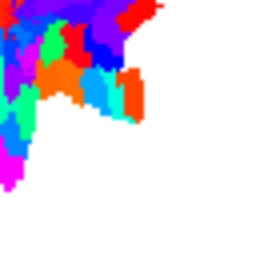

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 706       |
| time/              |           |
|    episodes        | 48        |
|    fps             | 3         |
|    time_elapsed    | 24509     |
|    total_timesteps | 96048     |
| train/             |           |
|    actor_loss      | -76.9     |
|    critic_loss     | 47.5      |
|    ent_coef        | 0.000322  |
|    ent_coef_loss   | -1.59e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 95947     |
----------------------------------


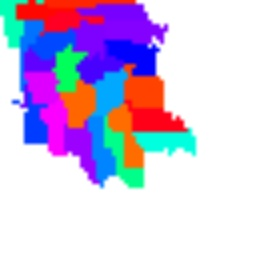

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 728       |
| time/              |           |
|    episodes        | 52        |
|    fps             | 3         |
|    time_elapsed    | 26559     |
|    total_timesteps | 104052    |
| train/             |           |
|    actor_loss      | -109      |
|    critic_loss     | 58        |
|    ent_coef        | 0.000226  |
|    ent_coef_loss   | -1.75e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 103951    |
----------------------------------


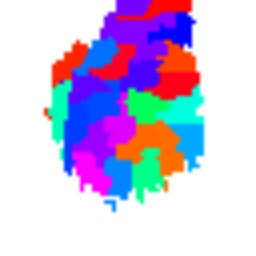

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 742      |
| time/              |          |
|    episodes        | 56       |
|    fps             | 3        |
|    time_elapsed    | 28606    |
|    total_timesteps | 112056   |
| train/             |          |
|    actor_loss      | -175     |
|    critic_loss     | 35.6     |
|    ent_coef        | 0.000203 |
|    ent_coef_loss   | -456     |
|    learning_rate   | 0.0003   |
|    n_updates       | 111955   |
---------------------------------


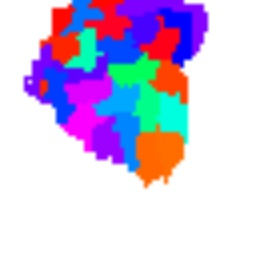

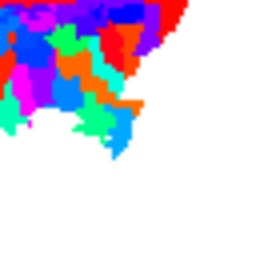

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 760      |
| time/              |          |
|    episodes        | 60       |
|    fps             | 3        |
|    time_elapsed    | 30651    |
|    total_timesteps | 120060   |
| train/             |          |
|    actor_loss      | -104     |
|    critic_loss     | 21       |
|    ent_coef        | 0.000179 |
|    ent_coef_loss   | 827      |
|    learning_rate   | 0.0003   |
|    n_updates       | 119959   |
---------------------------------


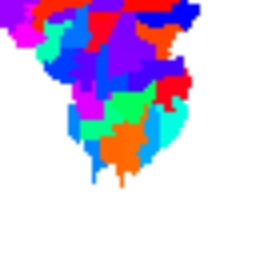

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 774      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 3        |
|    time_elapsed    | 32701    |
|    total_timesteps | 128064   |
| train/             |          |
|    actor_loss      | -116     |
|    critic_loss     | 25.9     |
|    ent_coef        | 0.00015  |
|    ent_coef_loss   | 519      |
|    learning_rate   | 0.0003   |
|    n_updates       | 127963   |
---------------------------------


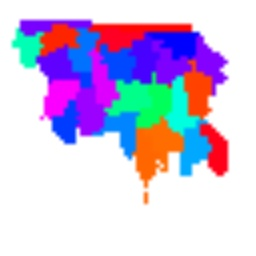

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 777      |
| time/              |          |
|    episodes        | 68       |
|    fps             | 3        |
|    time_elapsed    | 34747    |
|    total_timesteps | 136068   |
| train/             |          |
|    actor_loss      | -80.2    |
|    critic_loss     | 14.3     |
|    ent_coef        | 0.000128 |
|    ent_coef_loss   | 3.29e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 135967   |
---------------------------------


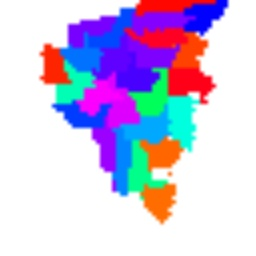

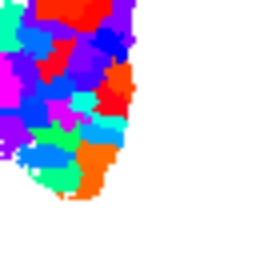

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 783       |
| time/              |           |
|    episodes        | 72        |
|    fps             | 3         |
|    time_elapsed    | 36794     |
|    total_timesteps | 144072    |
| train/             |           |
|    actor_loss      | -184      |
|    critic_loss     | 38.8      |
|    ent_coef        | 0.000157  |
|    ent_coef_loss   | -3.72e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 143971    |
----------------------------------


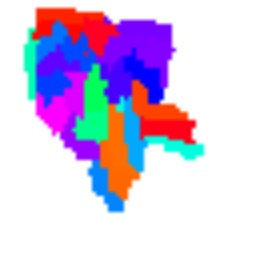

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 788      |
| time/              |          |
|    episodes        | 76       |
|    fps             | 3        |
|    time_elapsed    | 38843    |
|    total_timesteps | 152076   |
| train/             |          |
|    actor_loss      | -134     |
|    critic_loss     | 33.8     |
|    ent_coef        | 0.000209 |
|    ent_coef_loss   | -81      |
|    learning_rate   | 0.0003   |
|    n_updates       | 151975   |
---------------------------------


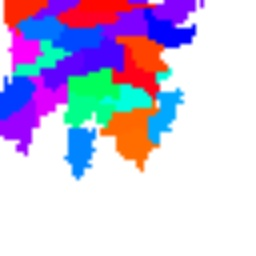

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 794      |
| time/              |          |
|    episodes        | 80       |
|    fps             | 3        |
|    time_elapsed    | 40892    |
|    total_timesteps | 160080   |
| train/             |          |
|    actor_loss      | -115     |
|    critic_loss     | 23.7     |
|    ent_coef        | 0.00017  |
|    ent_coef_loss   | 296      |
|    learning_rate   | 0.0003   |
|    n_updates       | 159979   |
---------------------------------


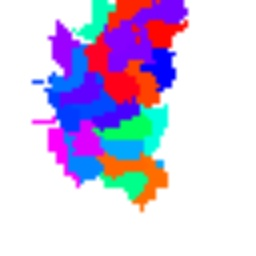

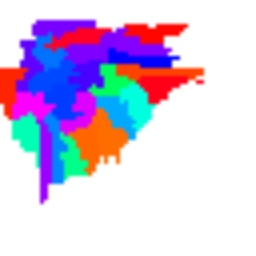

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 798      |
| time/              |          |
|    episodes        | 84       |
|    fps             | 3        |
|    time_elapsed    | 42938    |
|    total_timesteps | 168084   |
| train/             |          |
|    actor_loss      | -137     |
|    critic_loss     | 30       |
|    ent_coef        | 0.000135 |
|    ent_coef_loss   | 3.99e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 167983   |
---------------------------------


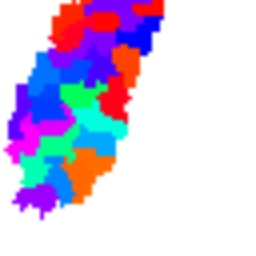

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 796      |
| time/              |          |
|    episodes        | 88       |
|    fps             | 3        |
|    time_elapsed    | 44985    |
|    total_timesteps | 176088   |
| train/             |          |
|    actor_loss      | -143     |
|    critic_loss     | 44.2     |
|    ent_coef        | 0.000127 |
|    ent_coef_loss   | 1.79e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 175987   |
---------------------------------


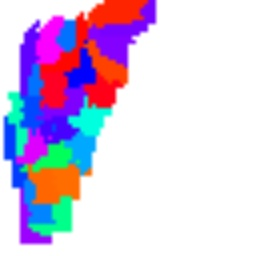

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 794      |
| time/              |          |
|    episodes        | 92       |
|    fps             | 3        |
|    time_elapsed    | 47033    |
|    total_timesteps | 184092   |
| train/             |          |
|    actor_loss      | -123     |
|    critic_loss     | 49.2     |
|    ent_coef        | 0.000144 |
|    ent_coef_loss   | 886      |
|    learning_rate   | 0.0003   |
|    n_updates       | 183991   |
---------------------------------


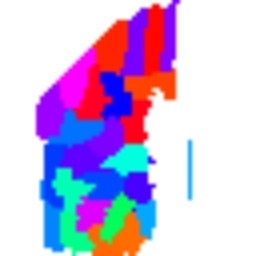

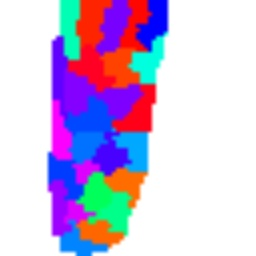

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 791       |
| time/              |           |
|    episodes        | 96        |
|    fps             | 3         |
|    time_elapsed    | 49081     |
|    total_timesteps | 192096    |
| train/             |           |
|    actor_loss      | -156      |
|    critic_loss     | 53.2      |
|    ent_coef        | 0.000158  |
|    ent_coef_loss   | -1.61e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 191995    |
----------------------------------


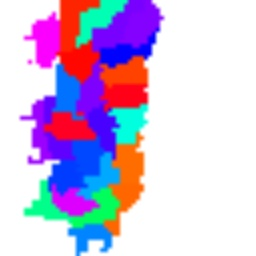

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 793      |
| time/              |          |
|    episodes        | 100      |
|    fps             | 3        |
|    time_elapsed    | 51132    |
|    total_timesteps | 200100   |
| train/             |          |
|    actor_loss      | -200     |
|    critic_loss     | 40.2     |
|    ent_coef        | 0.000167 |
|    ent_coef_loss   | 174      |
|    learning_rate   | 0.0003   |
|    n_updates       | 199999   |
---------------------------------


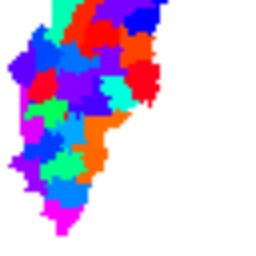

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 793       |
| time/              |           |
|    episodes        | 104       |
|    fps             | 3         |
|    time_elapsed    | 53181     |
|    total_timesteps | 208104    |
| train/             |           |
|    actor_loss      | -256      |
|    critic_loss     | 138       |
|    ent_coef        | 0.000155  |
|    ent_coef_loss   | -4.52e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 208003    |
----------------------------------


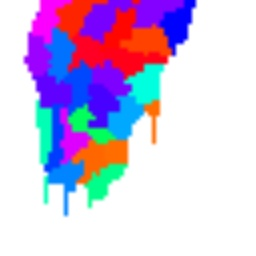

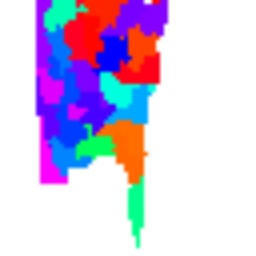

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 800      |
| time/              |          |
|    episodes        | 108      |
|    fps             | 3        |
|    time_elapsed    | 55231    |
|    total_timesteps | 216108   |
| train/             |          |
|    actor_loss      | -262     |
|    critic_loss     | 79.1     |
|    ent_coef        | 0.000168 |
|    ent_coef_loss   | 104      |
|    learning_rate   | 0.0003   |
|    n_updates       | 216007   |
---------------------------------


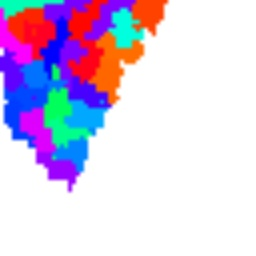

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 804      |
| time/              |          |
|    episodes        | 112      |
|    fps             | 3        |
|    time_elapsed    | 57290    |
|    total_timesteps | 224112   |
| train/             |          |
|    actor_loss      | -323     |
|    critic_loss     | 272      |
|    ent_coef        | 0.000271 |
|    ent_coef_loss   | 598      |
|    learning_rate   | 0.0003   |
|    n_updates       | 224011   |
---------------------------------


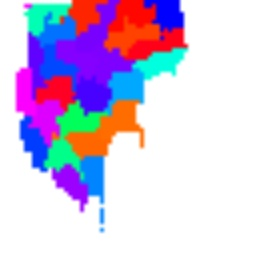

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 814       |
| time/              |           |
|    episodes        | 116       |
|    fps             | 3         |
|    time_elapsed    | 59339     |
|    total_timesteps | 232116    |
| train/             |           |
|    actor_loss      | -468      |
|    critic_loss     | 395       |
|    ent_coef        | 0.000299  |
|    ent_coef_loss   | -1.49e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 232015    |
----------------------------------


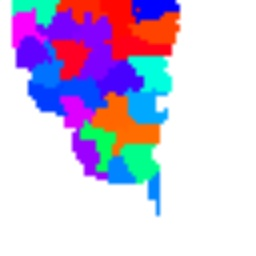

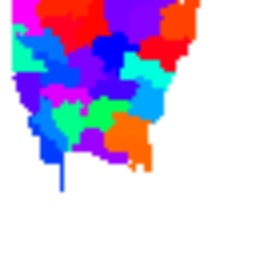

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 834      |
| time/              |          |
|    episodes        | 120      |
|    fps             | 3        |
|    time_elapsed    | 61387    |
|    total_timesteps | 240120   |
| train/             |          |
|    actor_loss      | -439     |
|    critic_loss     | 195      |
|    ent_coef        | 0.000388 |
|    ent_coef_loss   | -424     |
|    learning_rate   | 0.0003   |
|    n_updates       | 240019   |
---------------------------------


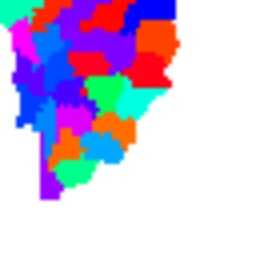

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 850      |
| time/              |          |
|    episodes        | 124      |
|    fps             | 3        |
|    time_elapsed    | 63434    |
|    total_timesteps | 248124   |
| train/             |          |
|    actor_loss      | -575     |
|    critic_loss     | 572      |
|    ent_coef        | 0.000428 |
|    ent_coef_loss   | 140      |
|    learning_rate   | 0.0003   |
|    n_updates       | 248023   |
---------------------------------


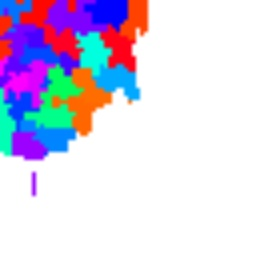

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 857       |
| time/              |           |
|    episodes        | 128       |
|    fps             | 3         |
|    time_elapsed    | 65484     |
|    total_timesteps | 256128    |
| train/             |           |
|    actor_loss      | -517      |
|    critic_loss     | 3.63e+03  |
|    ent_coef        | 0.00077   |
|    ent_coef_loss   | -1.32e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 256027    |
----------------------------------


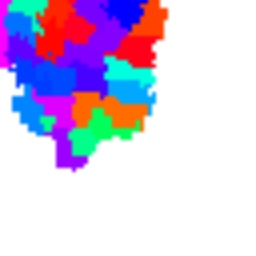

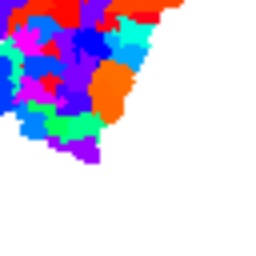

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 870       |
| time/              |           |
|    episodes        | 132       |
|    fps             | 3         |
|    time_elapsed    | 67532     |
|    total_timesteps | 264132    |
| train/             |           |
|    actor_loss      | -1.14e+03 |
|    critic_loss     | 2.96e+03  |
|    ent_coef        | 0.00089   |
|    ent_coef_loss   | -80       |
|    learning_rate   | 0.0003    |
|    n_updates       | 264031    |
----------------------------------


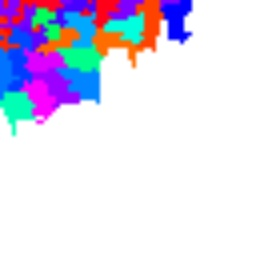

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 884      |
| time/              |          |
|    episodes        | 136      |
|    fps             | 3        |
|    time_elapsed    | 69582    |
|    total_timesteps | 272136   |
| train/             |          |
|    actor_loss      | -378     |
|    critic_loss     | 6.14e+03 |
|    ent_coef        | 0.0014   |
|    ent_coef_loss   | 1.95e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 272035   |
---------------------------------


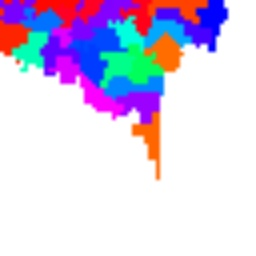

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 892       |
| time/              |           |
|    episodes        | 140       |
|    fps             | 3         |
|    time_elapsed    | 71629     |
|    total_timesteps | 280140    |
| train/             |           |
|    actor_loss      | -1.79e+03 |
|    critic_loss     | 5.16e+03  |
|    ent_coef        | 0.00226   |
|    ent_coef_loss   | 735       |
|    learning_rate   | 0.0003    |
|    n_updates       | 280039    |
----------------------------------


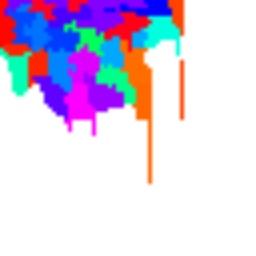

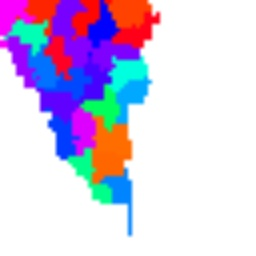

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 904      |
| time/              |          |
|    episodes        | 144      |
|    fps             | 3        |
|    time_elapsed    | 73680    |
|    total_timesteps | 288144   |
| train/             |          |
|    actor_loss      | -2.2e+03 |
|    critic_loss     | 1.17e+04 |
|    ent_coef        | 0.00281  |
|    ent_coef_loss   | -177     |
|    learning_rate   | 0.0003   |
|    n_updates       | 288043   |
---------------------------------


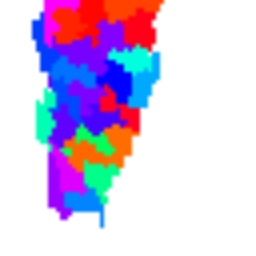

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 906      |
| time/              |          |
|    episodes        | 148      |
|    fps             | 3        |
|    time_elapsed    | 75730    |
|    total_timesteps | 296148   |
| train/             |          |
|    actor_loss      | -349     |
|    critic_loss     | 8.77e+03 |
|    ent_coef        | 0.00341  |
|    ent_coef_loss   | 120      |
|    learning_rate   | 0.0003   |
|    n_updates       | 296047   |
---------------------------------


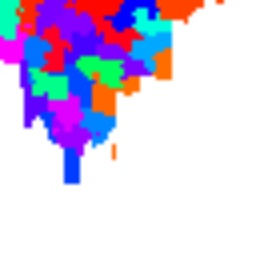

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 905       |
| time/              |           |
|    episodes        | 152       |
|    fps             | 3         |
|    time_elapsed    | 77781     |
|    total_timesteps | 304152    |
| train/             |           |
|    actor_loss      | -3.93e+03 |
|    critic_loss     | 3.85e+04  |
|    ent_coef        | 0.00588   |
|    ent_coef_loss   | 667       |
|    learning_rate   | 0.0003    |
|    n_updates       | 304051    |
----------------------------------


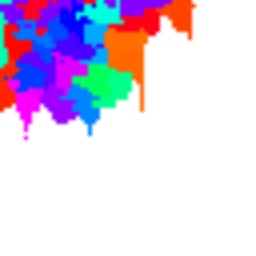

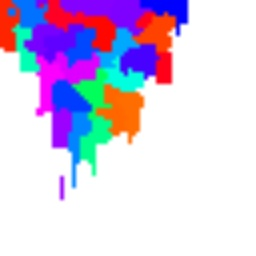

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 907       |
| time/              |           |
|    episodes        | 156       |
|    fps             | 3         |
|    time_elapsed    | 79830     |
|    total_timesteps | 312156    |
| train/             |           |
|    actor_loss      | -5.46e+03 |
|    critic_loss     | 6.82e+04  |
|    ent_coef        | 0.00929   |
|    ent_coef_loss   | -441      |
|    learning_rate   | 0.0003    |
|    n_updates       | 312055    |
----------------------------------


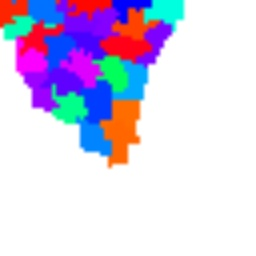

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 903       |
| time/              |           |
|    episodes        | 160       |
|    fps             | 3         |
|    time_elapsed    | 81880     |
|    total_timesteps | 320160    |
| train/             |           |
|    actor_loss      | -7.87e+03 |
|    critic_loss     | 7.2e+04   |
|    ent_coef        | 0.0115    |
|    ent_coef_loss   | 746       |
|    learning_rate   | 0.0003    |
|    n_updates       | 320059    |
----------------------------------


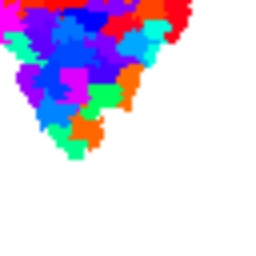

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 901      |
| time/              |          |
|    episodes        | 164      |
|    fps             | 3        |
|    time_elapsed    | 83927    |
|    total_timesteps | 328164   |
| train/             |          |
|    actor_loss      | -997     |
|    critic_loss     | 2.35e+04 |
|    ent_coef        | 0.0284   |
|    ent_coef_loss   | -464     |
|    learning_rate   | 0.0003   |
|    n_updates       | 328063   |
---------------------------------


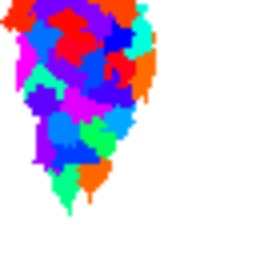

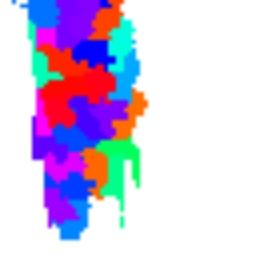

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 899      |
| time/              |          |
|    episodes        | 168      |
|    fps             | 3        |
|    time_elapsed    | 85980    |
|    total_timesteps | 336168   |
| train/             |          |
|    actor_loss      | -1.2e+04 |
|    critic_loss     | 3.24e+05 |
|    ent_coef        | 0.0223   |
|    ent_coef_loss   | 621      |
|    learning_rate   | 0.0003   |
|    n_updates       | 336067   |
---------------------------------


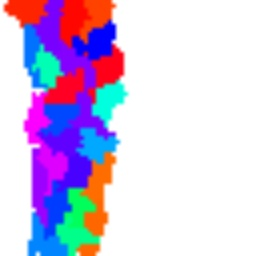

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 894       |
| time/              |           |
|    episodes        | 172       |
|    fps             | 3         |
|    time_elapsed    | 88032     |
|    total_timesteps | 344172    |
| train/             |           |
|    actor_loss      | -2.65e+04 |
|    critic_loss     | 5.86e+05  |
|    ent_coef        | 0.043     |
|    ent_coef_loss   | -449      |
|    learning_rate   | 0.0003    |
|    n_updates       | 344071    |
----------------------------------


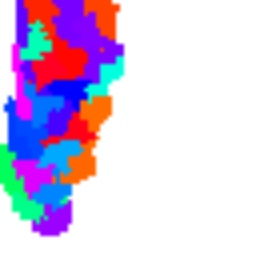

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 890       |
| time/              |           |
|    episodes        | 176       |
|    fps             | 3         |
|    time_elapsed    | 90086     |
|    total_timesteps | 352176    |
| train/             |           |
|    actor_loss      | -2.69e+04 |
|    critic_loss     | 5.09e+07  |
|    ent_coef        | 0.0643    |
|    ent_coef_loss   | 132       |
|    learning_rate   | 0.0003    |
|    n_updates       | 352075    |
----------------------------------


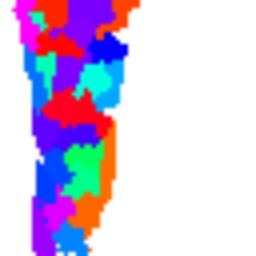

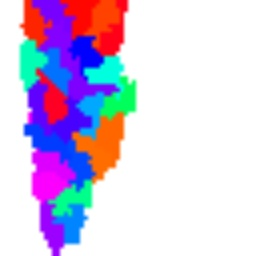

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 884       |
| time/              |           |
|    episodes        | 180       |
|    fps             | 3         |
|    time_elapsed    | 92142     |
|    total_timesteps | 360180    |
| train/             |           |
|    actor_loss      | -8.73e+03 |
|    critic_loss     | 9.6e+05   |
|    ent_coef        | 0.0684    |
|    ent_coef_loss   | -736      |
|    learning_rate   | 0.0003    |
|    n_updates       | 360079    |
----------------------------------


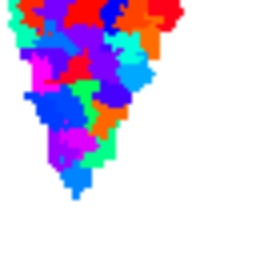

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 883       |
| time/              |           |
|    episodes        | 184       |
|    fps             | 3         |
|    time_elapsed    | 94201     |
|    total_timesteps | 368184    |
| train/             |           |
|    actor_loss      | -4.69e+04 |
|    critic_loss     | 1.2e+07   |
|    ent_coef        | 0.0592    |
|    ent_coef_loss   | -458      |
|    learning_rate   | 0.0003    |
|    n_updates       | 368083    |
----------------------------------


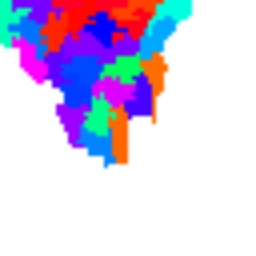

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 891       |
| time/              |           |
|    episodes        | 188       |
|    fps             | 3         |
|    time_elapsed    | 96258     |
|    total_timesteps | 376188    |
| train/             |           |
|    actor_loss      | -6.41e+04 |
|    critic_loss     | 1.1e+07   |
|    ent_coef        | 0.0883    |
|    ent_coef_loss   | -258      |
|    learning_rate   | 0.0003    |
|    n_updates       | 376087    |
----------------------------------


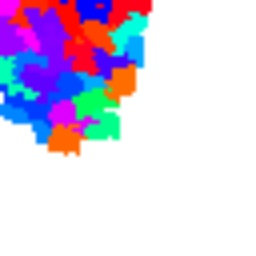

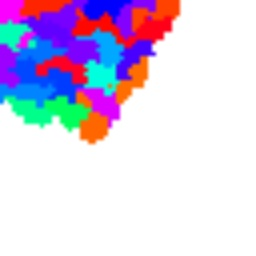

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | 900       |
| time/              |           |
|    episodes        | 192       |
|    fps             | 3         |
|    time_elapsed    | 98310     |
|    total_timesteps | 384192    |
| train/             |           |
|    actor_loss      | -1.32e+05 |
|    critic_loss     | 4.31e+07  |
|    ent_coef        | 0.103     |
|    ent_coef_loss   | -240      |
|    learning_rate   | 0.0003    |
|    n_updates       | 384091    |
----------------------------------


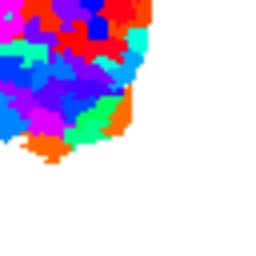

KeyboardInterrupt: 

In [6]:
model = SAC(CPM_SAC_Policy, env, tensorboard_log=os.path.join(result_dir), verbose=1 )#batch_size=64)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)
model.learn(total_timesteps=1000000, progress_bar=True)  # 学習を実行

In [ ]:

step = 200      # シミュレーションのエポック数
mcs_per_step = 20 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = '../results/cpm_torch_jp.mp4'
writer = LoopWriter(filename=video_filename, fps=10) # ループ動画ライター

obs, _ = env.reset()  # 環境をリセット

# --- シミュレーション実行 ---
for i in tqdm(range(step), desc="ステップ"):
    for k in range(mcs_per_step):
        action, _  = model.predict(obs, deterministic=True)  # モデルに基づいて行動を選択
        obs, reward, _ , _, _ = env.step(action)
    
    # --- 動画フレーム追加 ---
    frame_rgb = map_tensor_to_rgb(obs)
    writer.add(frame_rgb)

writer.close()
imshow_map(obs)